# One time pad

In the previous lesson we performed an attack over the Monoalphabetic cipher where the attacker (Charlie) only knew that Alice and Bob were communicating in english and that they were using this concrete cipher. Therefore the ciphertext is leaking information. Can we find a cipher whose ciphertext doesn't leak any information on the original message?. We are going to answer this question using the Vigenere cipher.


## Vigenère cipher revisited
First, lets copy paste the code for the Vingenère cipher already coded in the first notebook


In [1]:
from copy import deepcopy
from random import randrange
import string

characters = string.ascii_lowercase

def VigenereKeyGenerator(characters, secret_key_size = 5):
    """Generates a key of fixed lenght
    """
    n = len(characters)
    secret_key = ''
    while len(secret_key) < secret_key_size:
        secret_key += characters[randrange(n)]
    
    return secret_key


def ShiftLetter(letter: str, shiftby: str, characters: str, forward=True):
    """Shift a letter a certain ammount of spaces
    letter: an element from string.ascii_lowercase
    shiftby: a letter from string.asccii_lowercase indicating th ammount of shift
    """
    n = len(characters)
    char_to_num = {c:i for i, c in enumerate(characters)}

    if letter == ' ':
        return letter
    
    shift = char_to_num[shiftby]
    i = char_to_num[letter]
    
    if forward:
        return characters[(i + shift)%n]
    else:
        return characters[(i - shift)%n]


def VigenereEncryptDecrypt(message, characters, secret_key, encrypt = True):
    key_len = len(secret_key)
    
    encoded = ''
    for i, letter in enumerate(message):
        c = ShiftLetter(letter, secret_key[i%key_len], characters,forward=encrypt)
        encoded += c
        
    return encoded

## Downloading data from the book Nineteen Eighty Four

In [2]:
from utils import download_data, process_load_textfile
import string
import os

url = 'http://gutenberg.net.au/ebooks01/0100021.txt'
filename = 'Nineteen-eighty-four_Orwell.txt'
download_path = '/'.join(os.getcwd().split('/')[:-1]) + '/data/'

#download data to specified path
download_data(url, filename, download_path)

#load data and process
data = process_load_textfile(filename, download_path)

Have a look at the data

In [3]:
data[10000:11000]

'ook its smooth creamy paper a little yellowed by age was of a kind that had not been manufactured for at least forty years past he could guess however that the book was much older than that he had seen it lying in the window of a frowsy little junkshop in a slummy quarter of the town just what quarter he did not now remember and had been stricken immediately by an overwhelming desire to possess it party members were supposed not to go into ordinary shops dealing on the free market it was called but the rule was not strictly kept because there were various things such as shoelaces and razor blades which it was impossible to get hold of in any other way he had given a quick glance up and down the street and then had slipped inside and bought the book for two dollars fifty at the time he was not conscious of wanting it for any particular purpose he had carried it guiltily home in his briefcase even with nothing written in it it was a compromising possession the thing that he was about to

Let's remove the blank spaces for the next section

In [4]:
data = data.replace(" ", "")

## Counting letter frequencies

First we write a function to count the frequency of the letters for a given text

In [5]:
from typing import List, Tuple
from collections import Counter

def letter_frequency(text: str) -> List[Tuple[str, int]]:
    count = Counter(text.replace(" ",""))
    most_common = count.most_common()
    most_common.sort(key = lambda x: x[0])
    return most_common

And calculate the frequency for the book nineteen eighty four

In [6]:
freq = letter_frequency(data)
freq

[('a', 36523),
 ('b', 7653),
 ('c', 11636),
 ('d', 19022),
 ('e', 59619),
 ('f', 10188),
 ('g', 9283),
 ('h', 29164),
 ('i', 31950),
 ('j', 463),
 ('k', 3609),
 ('l', 18657),
 ('m', 10828),
 ('n', 31986),
 ('o', 35051),
 ('p', 8614),
 ('q', 409),
 ('r', 26126),
 ('s', 28972),
 ('t', 43877),
 ('u', 13037),
 ('v', 4313),
 ('w', 12243),
 ('x', 792),
 ('y', 9423),
 ('z', 306)]

And let's write a function that gives a bar plot for the frequencies:

In [7]:
import matplotlib.pyplot as plt

def freq_plotter(text: str, title: str) -> plt.figure:

    plt.clf()
    freq = letter_frequency(text)
    names = [x[0] for x in freq]
    values = [x[1] for x in freq]

    fig = plt.figure(figsize=(16,7))

    plt.bar(names, values)
    plt.title(title)
    return fig

<Figure size 432x288 with 0 Axes>

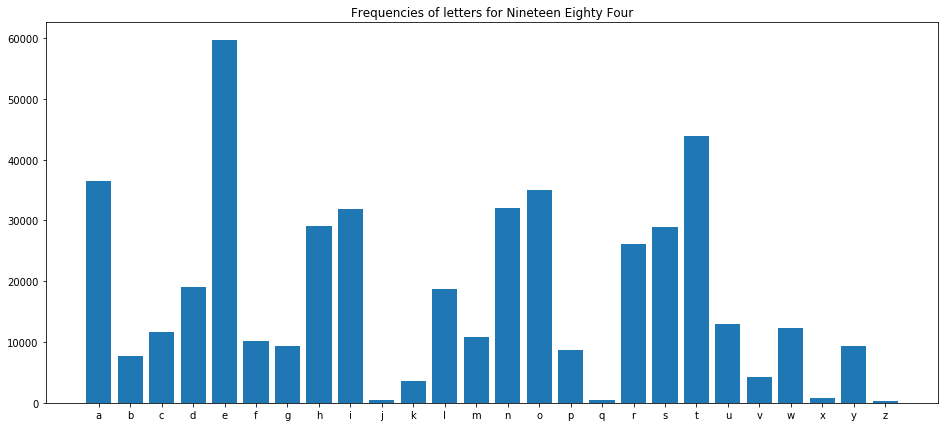

In [8]:
fig = freq_plotter(data, "Frequencies of letters for Nineteen Eighty Four")

And finally let's code another nice utility, a function that randomly draws a random portion of the text

In [151]:
from random import randrange, seed

def draw_sample(text: str, size: int) -> str:
    n = len(text)
    i_init = randrange(n)
    i_final = i_init + size
    
    c = ''
    for i in range(i_init, i_final):
        c += text[i%n]
    return c

In [152]:
seed(5)
draw_sample(data, 100)

'eeverythingwasallrighthefellasleepmurmuringsanityisnotstatisticalwiththefeelingthatthisremarkcontain'

## Counting frequencies with short key

Now let's count the frequency in the ciphertext for a randomly sampled text from the book. Let's begin with the shift cipher (i.e. Vigenere with key size 1)

In [153]:
seed(10)
message_size = len(data)//4
secret_key_size = 1
print(f"message_size = {message_size}\nsecret_key_size = {secret_key_size}")

# generating random message
message = draw_sample(data, message_size)

# generating secret key
secret_key = VigenereKeyGenerator(characters, secret_key_size)

# calculating ciphertext that Alice sends to Bob
ciphertext = VigenereEncryptDecrypt(message, characters, secret_key, encrypt=True)

# just to make sure Vigenere is well coded
assert message==VigenereEncryptDecrypt(ciphertext, characters, secret_key, encrypt=False), "something went wrong"

message_size = 115936
secret_key_size = 1


<Figure size 432x288 with 0 Axes>

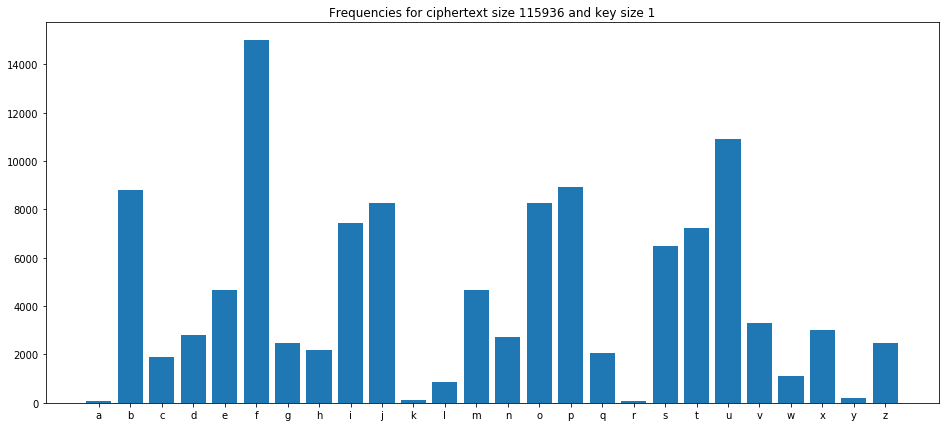

In [154]:
fig = freq_plotter(ciphertext, f"Frequencies for ciphertext size {message_size} and key size {secret_key_size}")

We observe that the frequencies of the letters are not the same, and therefore if the attacker knows Alice and Bob communicate in english he will probably be able to say that the shift is 1, i.e. the secret key is "b" because the most frequent letter in english is "e" and that corresponds to the peak in "f", therefore the shift is of one position. Here we can extract information from the ciphertext.

## Counting frequencies with large key

Instead of having a short key, let's take a super long key, actually the size of our message:

In [155]:
seed(20)
message_size = len(data)//4
secret_key_size = message_size
print(f"message_size = {message_size}\nsecret_key_size = {secret_key_size}")

# generating random message
message = draw_sample(data, message_size)

# generating secret key
secret_key = VigenereKeyGenerator(characters, secret_key_size)

# calculating ciphertext that Alice sends to Bob
ciphertext = VigenereEncryptDecrypt(message, characters, secret_key, encrypt=True)

# just to make sure Vigenere is well coded
assert message==VigenereEncryptDecrypt(ciphertext, characters, secret_key, encrypt=False), "something went wrong"

message_size = 115936
secret_key_size = 115936


<Figure size 432x288 with 0 Axes>

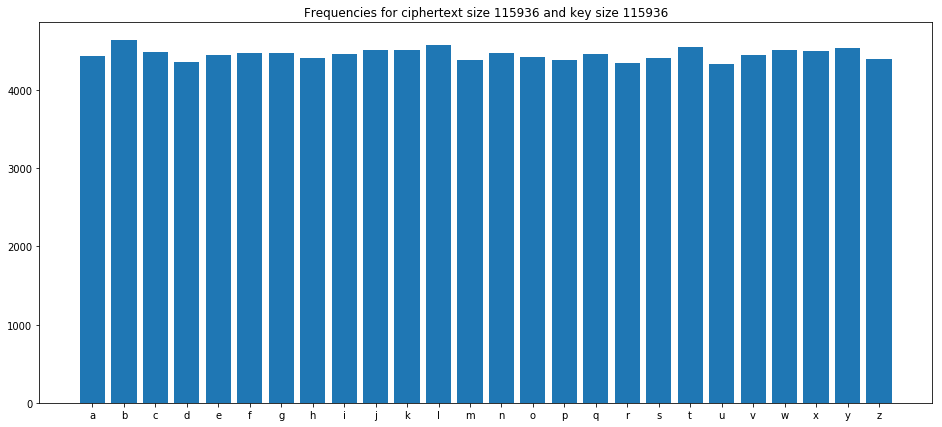

In [156]:
fig = freq_plotter(ciphertext, f"Frequencies for ciphertext size {message_size} and key size {secret_key_size}")

Great!. The attacker computes the frequency of the letters in the ciphertext and determines that the probability for each letter to appear is almost the same. In this context we can say that the ciphertext does not contain any information from the original message.

## The one time pad

Let's have a deeper look on what we've done in the previous section. First let's see what is the frequency for each letter when randomly generating the key

In [170]:
rdm_secret_keys = [VigenereKeyGenerator(characters, secret_key_size=1) for _ in range(5000)]
count = Counter(rdm_secret_keys)

In [171]:
count.most_common()

[('g', 214),
 ('h', 213),
 ('b', 204),
 ('q', 203),
 ('w', 203),
 ('e', 200),
 ('c', 199),
 ('o', 197),
 ('u', 196),
 ('x', 195),
 ('j', 195),
 ('l', 195),
 ('i', 195),
 ('k', 195),
 ('z', 193),
 ('f', 193),
 ('t', 192),
 ('v', 190),
 ('a', 189),
 ('m', 183),
 ('s', 182),
 ('d', 179),
 ('n', 178),
 ('p', 177),
 ('r', 171),
 ('y', 169)]

These are very similar, this means that the probability for generating any letter is almost the same, around 1/26.  Then when we encrypt what we do is to "shift" or "pad" our character by the key number. This means that the character in the ciphertext has probability 1/26 independent on what the character of the message was. We can formalise this using Bayesian statistics: 

A cryptosystem has perfect secrecy if for all possible messages and for all possible ciphertext the probability of finding a message is independent of the ciphertext

$$P(m|c) = P(m)$$

where $P(m)$ is the probability of message $m$ from the corpus of all possible messages $M$ and $P(m|c)$ is the conditional probability for $m$ having observed the ciphertext $c$ belonging to the corpus of all possible ciphertexts $C$.

Equivalently we can write 

$$P(m|c) = P(m|c^\prime)$$

for any two arbitrary ciphertext $c$ and $c^\prime$. This means that the probability for the message $m$ is independent of the ciphertext. 